In [100]:
%load_ext autoreload
from quantifier import *
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
%autoreload 2
lbdfHT,linfodf=readin(configfname="g6.yml")

no band detected in lane 5 (sid 02-B4)
no band detected in lane 11 (sid 02-H4)
no band detected in lane 13 (sid 02-C5)
no band detected in lane 17 (sid 02-G5)
no band detected in lane 18 (sid 02-H5)
6	02-C4	123156.0	47.9	42.2	9.0	0.017 +/- 0.005	0.64 +/- 0.19	0.031 +/- 0.009
7	02-D4	250416.0	30.3	29.7	6.0	0.033 +/- 0.015	1.82 +/- 0.83	0.055 +/- 0.025
8	02-E4	120708.0	43.4	44.6	8.0	0.016 +/- 0.006	0.68 +/- 0.27	0.029 +/- 0.012
9	02-G4	61560.0	119.5	134.1	24.0	0.008 +/- 0.004	0.11 +/- 0.06	0.013 +/- 0.007
10	control2	65880.0	nan	88.4	nan	0.009 +/- 0.004	nan +/- nan	nan +/- nan
10	control2	194868.0	nan	29.5	nan	0.025 +/- 0.013	nan +/- nan	nan +/- nan
12	02-B5	231084.0	53.5	50.5	12.0	0.031 +/- 0.012	0.87 +/- 0.33	0.046 +/- 0.018
14	02-D5	142848.0	77.8	86.9	15.0	0.021 +/- 0.004	0.46 +/- 0.09	0.036 +/- 0.007
15	02-E5	153072.0	55.5	53.0	14.0	0.022 +/- 0.006	0.52 +/- 0.14	0.029 +/- 0.008
16	02-F5	213912.0	49.7	53.3	12.0	0.030 +/- 0.008	0.84 +/- 0.23	0.042 +/- 0.012
19	01-G6	263160.0	46.8	49.3	

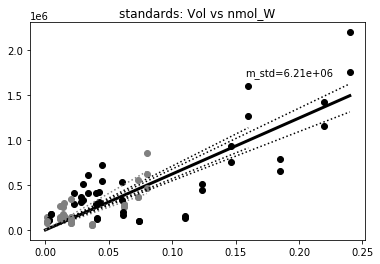

In [207]:
def propo(x,m):
    return m*x

pplus_ngin10uLHT={250:360,150:210,100:15,75:660,50:733.3,37:220,25:800,20:150,15:200,10:140}
pplus_winseqHT={250:51,150:29,100:19,75:14,50:10,37:5,25:5,20:3,15:3,10:2}

#start by getting calibration curve from relevant lanes
std_dfs_=[]
stdlanedf=linfodf[linfodf['sample']=='std']
for std in stdlanedf.index:
    lnum=stdlanedf['lane'].at[std]
    load_uL=stdlanedf['volume'].at[std]
    curdf=lbdfHT[lnum]
    std_dfs_.append(curdf)

    curdf['ng']=[np.nan for x in curdf.index]
    curdf['nmol']=[np.nan for x in curdf.index]
    curdf['nmolW']=[np.nan for x in curdf.index]
    for bidx in curdf.index:
        ngPer10uL=pplus_ngin10uLHT[curdf['Mol. Wt. (KDa)'].at[bidx]]
        ng_loaded=ngPer10uL*(load_uL/10)
        curdf['ng'].at[bidx]=ng_loaded
        curdf['nmol'].at[bidx]=ng_loaded/(curdf['Mol. Wt. (KDa)'].at[bidx]*1e3)
        curdf['nmolW'].at[bidx]=pplus_winseqHT[curdf['Mol. Wt. (KDa)'].at[bidx]]*curdf['nmol'].at[bidx]
comp_stdXA_=[std_df['nmolW'].at[x] for std_df in std_dfs_ for x in std_df.index]
comp_stdYA_=[std_df['Volume (Int)'].at[x] for std_df in std_dfs_ for x in std_df.index]
comp_std_linregress=curve_fit(propo,comp_stdXA_,comp_stdYA_)
comp_std_slope=comp_std_linregress[0][0]
comp_stdAdjYA_=[std_df['Adj. Volume (Int)'].at[x] for std_df in std_dfs_ for x in std_df.index]
comp_std_linregressAdj=curve_fit(propo,comp_stdXA_,comp_stdAdjYA_)
comp_std_slopeAdj=comp_std_linregressAdj[0][0]
#comp_std_linregress=linregress(comp_stdXA_,comp_stdYA_)

###this slope is 
comp_std_fitXA_=np.array([0,max(comp_stdXA_)])
comp_std_fitYA_=np.array([0,comp_std_fitXA_[1]*comp_std_slope])
#comp_std_fitYA_+=comp_std_linregress.intercept

fig,ax_std=plt.subplots()
ax_std.plot(comp_std_fitXA_,comp_std_fitYA_,c='black',lw=3)
ax_std.yaxis.get_major_formatter().set_powerlimits((0,1))
ax_std.set_title("standards: Vol vs nmol_W")
#plt.plot(comp_std_fitXA_,comp_std_fitYA_,c='black',lw=3)
std_xmax=ax_std.get_xlim()
std_ymiax=ax_std.get_ylim()
plt.text(0.9*ax_std.get_xlim()[1],1.1*ax_std.get_ylim()[1],'m_std={:.2e}'.format(comp_std_slope),ha='right')

for std_df in std_dfs_:
    stdvol=linfodf.loc[linfodf['lane']==std_df['Lane'].iat[0]]['volume'].values[0]
    kwHT={'c':'black'}
    if stdvol<10:
        kwHT['c']='gray'
    plt.plot('nmolW','Volume (Int)',data=std_df,marker='o',ls=' ',**kwHT)
    cur_linregress=curve_fit(propo,std_df['nmolW'].values,std_df['Volume (Int)'].values)#,data=std_df)
    cur_std_fitXA_=np.array([0,max(std_df['nmolW'].values)])
    cur_std_fitYA_=np.array([0,cur_std_fitXA_[1]*cur_linregress[0][0]])
    plt.plot(cur_std_fitXA_,cur_std_fitYA_,**kwHT,ls=':')
#how many other lanes are there?
qinfodf=linfodf[linfodf['sample']!='std']
num_lanes=qinfodf.shape[0]
#fig,ax_=plt.subplots(nrows=int(num_lanes/3)+1,ncols=3,figsize=(25,40))
#table columns:lane#, label,nmolW,uM,mgmL,mw-indep,mw-gelcalc
trows_=[]
for lidx,lindex in enumerate(qinfodf.index):
    #ax=ax_[int(lidx/3),lidx%3]
    #ax.plot(comp_std_fitXA_,comp_std_fitYA_,c='black',lw=3)
    lnum=qinfodf['lane'].at[lindex]
    load_uL=qinfodf['volume'].at[lindex]
    if lnum in lbdfHT.keys():
        curdf=lbdfHT[lnum]
    else:
        print('no band detected in lane {0} (sid {1})'.format(lnum,qinfodf['sample'].at[lindex]))
        continue

    curdf['nmolW']=[np.nan for x in curdf.index]
    curdf['nmol']=[np.nan for x in curdf.index]
    curdf['pconc']=[np.nan for x in curdf.index] #conc in uM
    curdf['mgmL']=[np.nan for x in curdf.index]
    curdf['nmolW_AdjVol']=[np.nan for x in curdf.index]
    curdf['nmol_AdjVol']=[np.nan for x in curdf.index]
    curdf['pconc_AdjVol']=[np.nan for x in curdf.index] #conc in uM
    curdf['mgmL_AdjVol']=[np.nan for x in curdf.index]
    for bidx in curdf.index:
        curdf['nmolW']=curdf['Volume (Int)'].at[bidx]/comp_std_slope
        curdf['nmol']=curdf['nmolW'].at[bidx]/qinfodf['wcount'].at[lindex]
        curdf['pconc']=1e6*curdf['nmol'].at[bidx]*1e-3/qinfodf['volume'].at[lindex]
        curdf['mgmL']=1e-6*curdf['pconc']*(qinfodf['mw'].at[lindex]*1e3)
        
        curdf['nmolW_AdjVol']=curdf['Adj. Volume (Int)'].at[bidx]/comp_std_slope
        curdf['nmol_AdjVol']=curdf['nmolW_AdjVol'].at[bidx]/qinfodf['wcount'].at[lindex]
        curdf['pconc_AdjVol']=1e6*curdf['nmol_AdjVol'].at[bidx]*1e-3/qinfodf['volume'].at[lindex]
        curdf['mgmL_AdjVol']=1e-6*curdf['pconc_AdjVol'].at[bidx]*(qinfodf['mw'].at[lindex]*1e3)
        trow=[]
        trow.append("{}".format(lnum))
        trow.append("{}".format(qinfodf['sample'].at[lindex]))
        trow.append("{}".format(curdf['Volume (Int)'].at[bidx]))
        trow.append("{:.1f}".format(qinfodf['mw'].at[lindex]))
        trow.append("{:.1f}".format(curdf['Mol. Wt. (KDa)'].at[bidx]))
        trow.append("{}".format(qinfodf['wcount'].at[lindex]))
        
        est_nmolW=0.75*curdf['nmolW'].at[bidx]+0.25*curdf['nmolW_AdjVol'].at[bidx]
        est_nmolW_err=0.5*(abs(curdf['nmolW'].at[bidx]-curdf['nmolW_AdjVol'].at[bidx]))
        est_nmolW_err=max(est_nmolW_err,0.1*est_nmolW)
        trow.append("{0:.3f} +/- {1:.3f}".format(est_nmolW,est_nmolW_err))
        
        est_uM=1e6*(est_nmolW/qinfodf['wcount'].at[lindex])*1e-3/qinfodf['volume'].at[lindex]
        est_uM_err=1e6*(est_nmolW_err/qinfodf['wcount'].at[lindex])*1e-3/qinfodf['volume'].at[lindex]
        trow.append("{0:.2f} +/- {1:.2f}".format(est_uM,est_uM_err))
        
        est_mgmL=1e-6*est_uM*(qinfodf['mw'].at[lindex]*1e3)
        est_mgmL_err=1e-6*est_uM_err*(qinfodf['mw'].at[lindex]*1e3)
        trow.append("{0:.3f} +/- {1:.3f}".format(est_mgmL,est_mgmL_err))
        
        trows_.append(trow)
for trow in trows_:
    rowstr=''
    for e in trow[:-1]:
        rowstr+=e+'\t'
    rowstr+=trow[-1]
    print(rowstr)
        #lane,label,volume,mw(indep),mw(gcalc),nmolW,uM,mgmL
        #ax.plot('nmolW','Volume (Int)',data=curdf,c='black',marker='o',ls=' ')
    
        #print(lnum,curdf['pconc'].at[bidx],curdf['pconc_AdjVol'].at[bidx],curdf['mgmL'].at[bidx],curdf['mgmL_AdjVol'].at[bidx])